# Define paths

In [1]:
from pathlib import Path

project_folder = str(Path(Path.cwd()).parents[1])

plots_folder = project_folder + "/TeX/figs/"

# Import solar model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

solar_model = pd.read_csv("./Data/bs2005agsopflux.csv", 
                          usecols=[1, 3, 7, 13],
                          names = ['radius', 'density_log_10', '8B fraction', 'hep fraction'],
                          sep=" ", skiprows=27, header=None)

solar_model['density'] = 10**solar_model['density_log_10']
solar_model

,radius,density_log_10,8B fraction,hep fraction,density
0,0.00041,2.011,0.000005,1.661000e-07,102.565193
1,0.00082,2.011,0.000014,4.865000e-07,102.565193
2,0.00123,2.011,0.000023,8.074000e-07,102.565193
3,0.00164,2.011,0.000035,1.245000e-06,102.565193
4,0.00205,2.011,0.000053,1.857000e-06,102.565193
...,...,...,...,...,...
1214,0.49795,0.071,0.000000,2.902000e-10,1.177606
1215,0.49836,0.069,0.000000,2.843000e-10,1.172195
1216,0.49877,0.067,0.000000,2.785000e-10,1.166810
1217,0.49918,0.065,0.000000,2.728000e-10,1.161449


<AxesSubplot:xlabel='r', ylabel='$n_e(r)$ [mol/cm${}^3$]'>

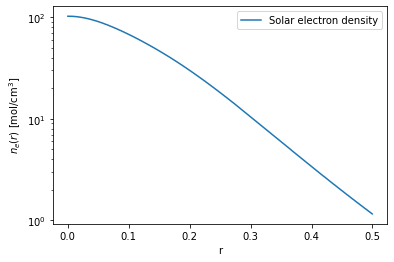

In [3]:
plot = solar_model.plot(x='radius', y='density', logy=True)
plot.set_xlabel("r")
plot.set_ylabel("$n_e(r)$ [mol/cm${}^3$]")
plot.legend(labels=['Solar electron density'])

plt.savefig(plots_folder + "sun_density.pdf")

plot

# Compute solar neutrino survival probability at Sun surface

In [4]:
def Vk(Deltam2, E, ne):
    """Vk(Deltam2, E, ne) computes the ratio V/k between the matter and vacuum terms in neutrino oscillations.
    - Deltam2 is the squared mass difference, in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3;
See also Eq.s 4.17, 4.18 in 1802.05781."""
    return (3.868e-7)/(2.533) * (ne / (Deltam2 / E))

In [5]:
from numpy import cos, sin, arcsin, tan, arctan, pi

def th12_M (th12, th13, DeltamSq21, E, ne):
    """th12_M(th12, th13, DeltamSq21, E, ne) computes the mixing angle \theta_{12} in matter.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSq21 is the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arctan(tan(2*th12) / (1 - (cos(th13)**2)/(cos(2* th12)) * Vk(DeltamSq21, E, ne))) / 2) % (pi/2)


def th13_M (th13, DeltamSq31, E, ne):
    """th13_M(th13, DeltamSq31, E, ne) computes the mixing angle \theta_{13} in matter.
    - th13 is the vacuum mixing angles \theta_{13} in radians;
    - DeltamSq31 is the vacuum squared mass difference between mass eigenstates 3 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arcsin(sin(th13) * (1 + Vk(DeltamSq31, E, ne) * cos(th13)**2))) % (pi/2)

In [6]:
def Pnuenue (th12, th13, DeltamSq21, DeltamSq31, E, ne):
    """Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne) computes the survival probability of an electron neutrino
    neutrino at the Sun surface in the adiabatic approximation, as a function of vacuum oscillation parameters.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density at neutrino production point, in units of mol/cm^3.
See also Eq. 6.14 in FiuzadeBarros:2011qna."""
    th12m = th12_M(th12, th13, DeltamSq21, E, ne)
    th13m = th13_M(th13, DeltamSq31, E, ne)
    return cos(th13)**2 * cos(th13m)**2 * (cos(th12)**2 * cos(th12m)**2 + sin(th12)**2 * sin(th12m)**2) + sin(th13)**2 * sin(th13m)**2

<AxesSubplot:xlabel='r', ylabel='Neutrino fraction'>

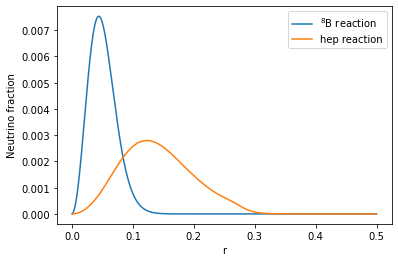

In [7]:
plot = solar_model.plot(x='radius', y=['8B fraction', 'hep fraction'])
plot.set_xlabel('r')
plot.set_ylabel('Neutrino fraction')
plot.legend(labels=['${}^8$B reaction', 'hep reaction'])

plt.savefig(plots_folder + "reaction_fraction.pdf")

plot

In [8]:
from scipy import integrate
import numpy as np

def PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction):
    """PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction) computes the
    survival probability at Sun surface for an electron with energy E produced in a specific reaction.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - radius_samples is a list of solar relative radius values where density and fraction are sampled;
    - density is the list of electron densities at radii radius_samples, in units of mol/cm^3;
    - fraction is the relative fraction of neutrinos produced in the considered reaction, sampled at radius_samples."""
    
    IntegratedFraction = integrate.trapezoid(y=fraction, x=radius_samples)
    PnuenueRadius = np.array([Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne_r) for ne_r in density])
    
    return integrate.trapezoid(y=(PnuenueRadius * fraction), x = radius_samples) / IntegratedFraction

In [9]:
from math import sqrt

th12 = arctan(sqrt(0.469))
th13 = arcsin(sqrt(0.01))
DeltamSq21 = 7.9e-5
DeltamSq31 = 2.46e-3
E = 10
ne = 100
radius_samples = solar_model.radius
density = solar_model.density
fraction = solar_model['8B fraction']

xrange = np.arange(1,20,0.1)
ProbB8 = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['8B fraction']) for E in xrange]
Probhep = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['hep fraction']) for E in xrange]

In [10]:
SNO_B8 = pd.read_csv("./Data/B8.csv", names=['energy', 'Pnuenue'])
SNO_hep = pd.read_csv("./Data/hep.csv", names=['energy', 'Pnuenue'])

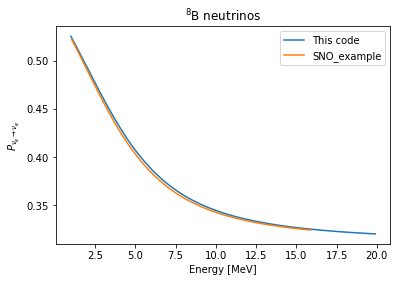

In [11]:
plt.plot(xrange, ProbB8, label="This code")
plt.plot(SNO_B8.energy, SNO_B8.Pnuenue, label='SNO_example')
plt.title("${}^8$B neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "8B_SNO_cmparison.pdf")

plt.show()

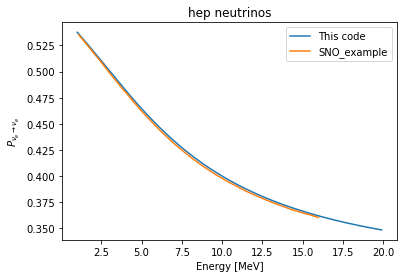

In [12]:
plt.plot(xrange, Probhep, label="This code")
plt.plot(SNO_hep.energy, SNO_hep.Pnuenue, label='SNO_example')
plt.title("hep neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "hep_SNO_comparison.pdf")

plt.show()

# Earth regeneration

### It is not necessary to define a new function for undergroud detector:
- for $0 \leq \eta \leq \pi/2$: use total path for first half of propagation, then stop at $r_{det} = 1 - h$ for second half;
- for $\pi/2 \leq \eta \leq \pi$: just use downstream path (with constant density? The density variation is at most $10^{-4}$ for SNO)

In [13]:
import numpy as np
from math import sin, cos, sqrt

def EarthDensity (x = 0, eta = 0, parameters = False): 
    """EarthDensity(x, eta, integrated) computes:
    - if integrated = False: the value of Earth electron density in units of mol/cm^3 for trajectory coordinate 
    x and nadir angle eta;
    -if integrated = True: two lists containing the values of the integrated electron 
    densities along each shell crossed by a path with nadir angle eta, to be inputed in 
    the 1st and 2nd order terms in the evolutor Magnus expansion.
See hep-ph/9702343 for the definition of trajectory coordinate."""
    
    # The density profile is symmetric with respect to x=0 
    x = np.abs(x)
    
    # If x > cos(eta) the trajectory coordinate is beyond Earth surface, thus density is zero.
    if ((~parameters) & (x > cos(eta))):
        return 0
    else:
        # Define the Earth density parametrisation, in units of mol/cm^3, following hep-ph/9702343
        alpha = np.array([6.099, 5.803, 3.156, -5.376, 11.540])
        beta = np.array([-4.119, -3.653, -1.459, 19.210, -20.280])
        gamma = np.array([0, -1.086, 0.280, -12.520, 10.410])

        rj = np.array([0.192, 0.546, 0.895, 0.937, 1])

        # Select the index "idx_shells" in rj such that for i >= idx_shells => rj[i] > sin(eta)
        # The shells having rj[i] > sin(eta) are the ones crossed by a path with nadir angle = eta
        idx_shells = np.searchsorted(rj, sin(eta))
        
        # Keep only the parameters for the shells crossed by the path with nadir angle eta
        alpha_prime = alpha[idx_shells::] + beta[idx_shells::] * sin(eta)**2 + gamma[idx_shells::] * sin(eta)**4
        beta_prime = beta[idx_shells::] + 2 * gamma[idx_shells::] * sin(eta)**2
        gamma_prime = gamma[idx_shells::]

        # Compute the value of the trajectory coordinates xj at each shell crossing
        xj = np.sqrt( (rj[idx_shells::])**2 - sin(eta)**2 )

        # The index "idx" determines within which shell xj[idx] the point x is
        idx = np.searchsorted(xj, x)
        
        # If integrated = true, the function returns the values of the integrated electron densities for the
        # path along each crossed shell
        if parameters:
            # Define xj_zero, a list containing the values of trajectory coordinates for each shell boundary
            # (including the lower end x = 0), user to perform integration on each shell
            
            # Return the value of the integrated densities along each crossed shell
            return [ [ [alpha_prime[i], beta_prime[i], gamma_prime[i]], xj[i] ] for i in range(len(alpha_prime))]
       
        # If integrated = False, return the value of electron density at trajectory point x for nadir angle eta
        else:
            return alpha_prime[idx] + beta_prime[idx] * x**2 + gamma_prime[idx] * x**4

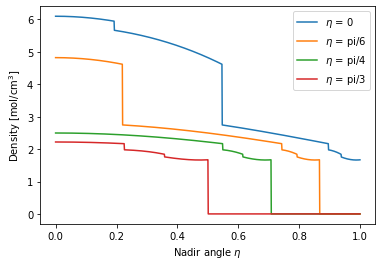

In [14]:
import matplotlib.pyplot as plt
from math import pi

x = np.arange(0,1,0.001)
eta = [0, pi/6, pi/4, pi/3]
labels = ["0", "pi/6", "pi/4", "pi/3"]

density = [ [EarthDensity(r, n) for r in x] for n in eta]

plt.xlabel("Nadir angle $\eta$")
plt.ylabel("Density [mol/cm${}^3$]")
for i in range(len(density)):
    plt.plot(x,density[i], label = "$\eta$ = %s" %labels[i])
plt.legend()
plt.savefig(plots_folder + "earth_density.pdf")
    
plt.show()

The density can be approximated as constant for downstream paths

In [15]:
h = 2 / 6.371e3

(EarthDensity(1) - EarthDensity(1-h))/(EarthDensity(1) + EarthDensity(1-h))

0.00010027377254072573

# Compute Earth matter regeneration

In [16]:
import numpy as np
from math import cos, sin, sqrt, atan
from cmath import exp

In [17]:
# Earth radius R_E: since we integrate over the dimensionless parameter r = R/R_E, the Hamiltonian must be
# multiplied by R_E
R_E = 6.371e6 # meters

# Matter potential
def MatterPotential (n):
    """MatterPotential(n) computes the matter potential due to an electron density n, expressed in mol/cm^3
See Eq. 4.17 in 1802.05781."""
    # n in mol / cm^3
    return R_E * 3.868e-7 * n

# Kinetic potential
def k(mSq, E):
    """k(mSq, E) computes the kinetic potential for an ultrarelativistic neutrino:
    - mSq is the squared mass (or mass difference) in units of eV^2;
    - E is the neutrino energy in MeV.
See Eq. 4.18 in 1802.05781."""
    # mSq in eV^2, E in MeV
    return R_E * 2.533 * mSq / E

In [63]:
# Computes coefficients of the characteristic equation for the matrix T = H - Tr(H)/3, cf. hep-ph/9910546 
def c0 (m1Sq, m2Sq, m3Sq, E, n):
    """c0(m1Sq, m2Sq, m3Sq, E, n) computes the coefficient c_0 defined in hep-ph/9910546, for the specific case
    in which the mixing matrix is the reduced one U = R_{13} R_{12}:
    - miSq are the squared masses (or mass differences) in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - n is the electron matted density, in units of mol/cm^3.
See hep-ph/9910546 for the full context of the definition."""
    [k1, k2, k3] = k(np.array([m1Sq, m2Sq, m3Sq]), E)
    V = MatterPotential(n)
    
    return (-4*(k1 + k2 - 2*k3)*(2*k1 - k2 - k3)*(k1 - 2*k2 + k3) + 
  3*(k1**2 - 4*k1*k2 + k2**2 + 2*(k1 + k2)*k3 - 2*k3**2)*V + 
  3*(k1 + k2 - 2*k3)*V**2 - 8*V**3 - 18*(k1 - k2)*V*(k1 + k2 - 2*k3 + V)*
   cos(2*th12)*cos(th13)**2 - 9*V*(k1**2 + k2**2 - 2*k3*(k3 + V) + 
    k2*(2*k3 + V) + k1*(-4*k2 + 2*k3 + V))*cos(2*th13) )/108


def c1(m1Sq, m2Sq, m3Sq, E, n):
    """c1(m1Sq, m2Sq, m3Sq, E, n) computes the coefficient c_1 defined in hep-ph/9910546, for the specific case
    in which the mixing matrix is the reduced one U = R_{13} R_{12}:
    - miSq are the squared masses (or mass differences) in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - n is the electron matted density, in units of mol/cm^3.
See hep-ph/9910546 for the full context of the definition."""
    [k1, k2, k3] = k(np.array([m1Sq,m2Sq,m3Sq]), E)
    V = MatterPotential(n)
    
    return (-4*(k1**2 - k1*k2 + k2**2 - (k1 + k2)*k3 + k3**2) + (k1 + k2 - 2*k3)*V - 
  4*V**2 + 6*(-k1 + k2)*V*cos(2*th12)*cos(th13)**2 - 
  3*(k1 + k2 - 2*k3)*V*cos(2*th13))/12


# Computes the solutions of the characteristic equation for the matrix T = H - Tr(H)/3, cf. hep-ph/9910546 
def lambdas (c0, c1):
    """lambdas(c0, c1) computes the solutions (roots) of the characteristic equation for the matrix 
    T = H - Tr(H)/3, i.e. the quantities \lambda_i defined in Eq.s (33-35) in hep-ph/9910546:
    - c0, c1 are the coefficients of the characteristic equations for the matrix T = H - Tr(H)/3, they are
    computed by the functions c0(m1Sq, m2Sq, m3Sq, E, n) and c1(m1Sq, m2Sq, m3Sq, E, n) for the specific
    scenario in which the mixing matrix is the reduced one U = R_{13} R_{12}.
    
    The function returns a list containing the 3 roots.
See hep-ph/9910546 for the full context of the definition."""
    l1 = -(sqrt(-(1/3) * c1)*cos(1/3 * atan(1/c0 * sqrt(-c0**2 - 4/27 * c1**3))) + 
   sqrt(-c1) * sin(1/3 * atan(1/c0 * sqrt(-c0**2 - 4/27 * c1**3))))
    l2 = -( sqrt(-(1/3) * c1)*cos(1/3 * atan(1/c0 * sqrt(-c0**2 - 4/27 * c1**3))) - 
   sqrt(-c1) * sin(1/3 * atan(1/c0 * sqrt(-c0**2 - 4/27 * c1**3))))
    l3 = (2 * sqrt(-(1/3) * c1) * cos(1/3 * atan(1/c0 * sqrt(-c0**2 - 4/27 * c1**3))) )
    
    return [l1, l2, l3]



# Compute the integrals required for the first order correction in the evolutor
def Iab (la, lb, atilde, b, c, x2, x1):
    """Iab(la, lb, atilde, b, c, x2, x1) computes the definite integral: 
    \int_x1^x2 dx e^{- i la (x2-x)} (atilde + b x^2 + c x^4) e^{- i lb (x-x1)}.
    
    It is assumed that the integral of (atilde + b x^2 + c x^4) vanished on the considered interval, i.e.
    atilde (x2-x1) + b (x2^3 -x1^3)/3 + c (x2^5 - x1^5)/5 = 0.
    
    The integral is identically zero if la == lb.
    
    The analytic solution is numerically instable when la ~ lb, thus for the case in which 
    abs((la - lb) / (la + lb)) < 1e-2 we compute the 2nd order Taylor expansion around the point la == lb,
    which is numerically stable."""
    
    # The analytic solution depends on la, lb only via Dl = la - lb, except for a common phase factor.
    Dl = la - lb
    
    # If la == la the integral is identically zero.
    if Dl == 0:
        return 0
    
    # For small differences between la and lb we compute the 2nd order Taylor expansion around la == lb,
    # which is numerically stable
    elif np.abs(Dl / (la + lb)) < 1e-2:
        return exp(1j*lb*(-x2 + x1))*(Dl*((-1j/2)*atilde*(x2 - x1)**2 - (1j/12)*b*(x2**4 - 4*x2*x1**3 + 
          3*x1**4) - (1j/30)*c*(x2**6 - 6*x2*x1**5 + 5*x1**6)) + 
          Dl**2*(-(atilde*(x2 - x1)**3)/6 - 
        (b*(x2**5 - 10*x2**2*x1**3 + 15*x2*x1**4 - 6*x1**5))/60 - 
        (c*(x2**7 - 21*x2**2*x1**5 + 35*x2*x1**6 - 15*x1**7))/210))

    # In the other regions we compute the full analytic solution.
    else:
        return exp(1j*lb*(-x2 + x1))*((atilde*(-1j + 1j/exp(1j*Dl*(x2 - x1))))/Dl + 
                (b*(2*1j + 2*Dl*x2 - 1j*Dl**2*x2**2 + (1j*(-2 + (2*1j)*Dl*x1 + Dl**2*x1**2))/
          exp(1j*Dl*(x2 - x1))))/Dl**3 - 
          (1j*c*(24 + Dl*x2*(-24*1j + Dl*x2*(-12 + Dl*x2*(4*1j + Dl*x2))) - 
             (24 + Dl*x1*(-24*1j + Dl*x1*(-12 + Dl*x1*(4*1j + Dl*x1))))/
          exp(1j*Dl*(x2 - x1))))/Dl**5)

## Define PMNS matrices

In [54]:
# These are the orthogonal/unitary matrices factorising the PMNS matrix, 
# U_{PMNS} = R_{23} \Delta R_{13} \Delta^* R_{12}
def R23(th):
    return np.matrix([
        [1, 0, 0],
        [0, cos(th), sin(th)],
        [0, -sin(th), cos(th)]
    ])

def R13(th):
    return np.matrix([
        [cos(th), 0, sin(th)],
        [0, 1, 0],
        [-sin(th), 0, cos(th)]
    ])

def R12(th):
    return np.matrix([
        [cos(th), sin(th), 0],
        [-sin(th), cos(th), 0],
        [0, 0, 1]
    ])

def Delta(d):
    return np.matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, exp(1j*d)]
    ])

In [64]:
def Upert (m1Sq, m2Sq, m3Sq, E, th12, th13, x2=1, x1=0, a=0, b=0, c=0):
    """Upert(m1Sq, m2Sq, m3Sq, E, th12, th13, x2=1, x1=0, a=0, b=0, c=0, order = 1) computes the evolutor
    for an ultrarelativistic neutrino state in flavour basis, for a reduced mixing matrix U = R_{13} R_{12}
    (the dependence on th_{23} and CP-violating phase \delta_{CP} can be factorised) for a density profile 
    parametrised by a 4th degree even poliomial in the trajectory coordinate, to 1st order corrections around
    the mean density value:
    - miSq are the squared masses (or mass differences) in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - thij are the PMNS mixing angles;
    - x1 (x2) is the starting (ending) point in the path;
    - a, b, c parametrise the density profile on the path, n_e(x) = a + b x^2 + c x^4.
See hep-ph/9702343 for the definition of the perturbative expansion of the evolutor in a 2-flavours case."""
    [k1, k2, k3] = k(np.array([m1Sq, m2Sq, m3Sq]), E)
    naverage = (a * (x2 - x1) + b * (x2**3 - x1**3)/3 + c * (x2**5 - x1**5)/5) / (x2 - x1)
    V = MatterPotential(naverage)
    atilde = a - naverage
    L = (x2 - x1)

    U = np.dot(R13(th13), R12(th12))
    H = multi_dot([U, np.diag([k1, k2, k3]), U.transpose()]) + np.diag([V, 0, 0])
    tr = np.sum([k1, k2, k3, V])
    T = H - tr/3 * np.identity(3)

    c0_loc = c0(m1Sq, m2Sq, m3Sq, E, naverage)
    c1_loc = c1(m1Sq, m2Sq, m3Sq, E, naverage)

    lam = lambdas(c0_loc, c1_loc)

    M = [(1 / (3*la**2 + c1_loc)) * 
                    ((la**2 + c1_loc) * np.identity(3) + la * T + np.dot(T,T)) for la in lam]

    u0 = np.sum([exp(-1j * (lam[i] + tr/3) * L) * M[i] for i in range(len(lam))], 0)

    u1 = np.sum([multi_dot([M[idx_a], np.diag([-1j * MatterPotential(Iab(lam[idx_a] + tr/3, lam[idx_b] + tr/3, 
                                                                         atilde, b, c, x2, x1)), 0, 0]),
                        M[idx_b]]) for idx_a in range(3) for idx_b in range(3)], 0)

    return u0 + u1

## Perform numerical tests and comparison with analytic solutions, for a path crossing a single shell

In [56]:
from scipy.integrate import complex_ode
import matplotlib.pyplot as plt

In [57]:
from numpy.linalg import multi_dot

DeltamSq21 = 7.42e-5
DeltamSq31 = 2.514e-3
E = np.random.uniform(1,20)
[th12, th13, th23, d] = [0.583638, 0.149575, 0.855211, 3.40339]

r13 = R13(th13)
r12 = R12(th12)
r23 = R23(th23)
delta = Delta(d)

pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

eta = 0
U = np.dot(r13, r12)
x1, x2 = 0, 0.192
a, b, c = 6.099, -4.119, 0
naverage = (a * (x2 - x1) + b * (x2**3 - x1**3)/3 + c * (x2**5 - x1**5)/5) / (x2 - x1)

H0 = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()]) + np.diag([MatterPotential(naverage), 0, 0])
Hk = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()])

H0

matrix([[  493.0487306 ,   207.19889493,  2254.59408033],
        [  207.19889493,   317.2996478 ,   -31.22498497],
        [ 2254.59408033,   -31.22498497, 15099.13179754]])

#### Numerical solution at 0th order

In [58]:
def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * np.dot(H0, [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model)

nu.set_integrator("Isoda")
nu.set_initial_value(nu0, 0)


x = np.linspace(x1, x2, 10**3)
sol = [nu.integrate(xi) for xi in x[1::]]
sol.insert(0, np.array(nu0)[0])
    
#print(nu.t, nu.y, nu.successful())

Zero_num = sol[-1]
print(x[-1], Zero_num, nu.successful())

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


0.192 [ 0.37958884-0.39634766j  0.67636634-0.18591026j -0.16191914-0.42337954j] True


#### Analitical solution at 0th order

In [65]:
Zero_an = np.dot(Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, x2, x1, naverage, b=0, c=0), nu0.transpose()).transpose()
Zero_an

matrix([[ 0.37966327-0.39656926j,  0.67636634-0.18591027j,
         -0.1614257 -0.42484857j]])

#### Norm of the difference between numerical and analytical solutions

In [66]:
np.linalg.norm(Zero_num - Zero_an)

0.0015672246468494365

##### Plot the numerical solution

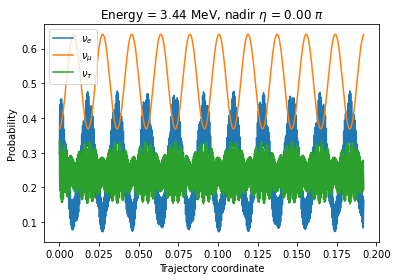

In [41]:
probs = np.square(np.abs(sol))

plt.xlabel("Trajectory coordinate")
plt.ylabel("Probability")
plt.title("Energy = %.2f MeV, nadir $\eta$ = %.2f $\pi$" % (E, eta/pi))
plt.plot(x, probs, label=["$\\nu_e$", "$\\nu_\mu$", "$\\nu_\\tau$"])
plt.legend()

plt.show()

#### Full numerical solution

In [68]:
def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * np.dot(Hk + np.diag([MatterPotential(EarthDensity(t)),0,0]), [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model)

nu.set_integrator("Isoda")
nu.set_initial_value(nu0, 0)


x = np.linspace(x1, x2,10**3)
sol = [nu.integrate(xi) for xi in x[1::]]
sol.insert(0, np.array(nu0)[0])

One_num = sol[-1]
print(x[-1], One_num, nu.successful() )

0.192 [ 0.37948863-0.39621677j  0.6764616 -0.18606034j -0.16176054-0.42339324j] True


#### Analytic solution at 1st order

In [70]:
One_an = np.dot(Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, x2, x1, a, b, c), nu0.transpose()).transpose()
One_an

matrix([[ 0.37954202-0.39643886j,  0.67646204-0.18605971j,
         -0.16140623-0.4248683j ]])

#### Check differences between numerical, 0th and 1st analytic solutions

In [71]:
err = [np.linalg.norm(Zero_num - Zero_an), 
 np.linalg.norm(One_num - Zero_an),
 np.linalg.norm(One_num - One_an)]

print(err, err[2]<err[1])

[0.0015672246468494365, 0.0015544972231211775, 0.001534117436751018] True


##### Plot the numerical solution

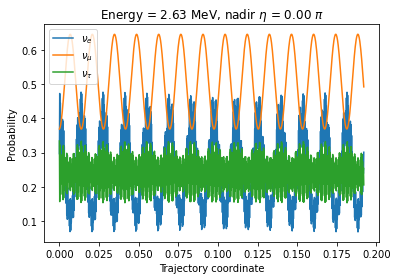

In [72]:
probs = np.square(np.abs(sol))

plt.xlabel("Trajectory coordinate")
plt.ylabel("Probability")
plt.title("Energy = %.2f MeV, nadir $\eta$ = %.2f $\pi$" % (E, eta/pi))
plt.plot(x, probs, label=["$\\nu_e$", "$\\nu_\mu$", "$\\nu_\\tau$"])
plt.legend()

plt.show()

# Path crossing multiple shells

In [73]:
from math import pi

eta = np.random.uniform(0, pi/2)
E = np.random.uniform(1,20)


H0 = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()]) + np.diag([MatterPotential(naverage), 0, 0])
Hk = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()])


params = EarthDensity(eta=eta, parameters=True)

evolutors = [Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, params[i][1], params[i-1][1] if i > 0 else 0, 
                   params[i][0][0], params[i][0][1], params[i][0][2]) for i in reversed(range(len(params)))]

evolutor_half = multi_dot(evolutors) if len(evolutors) > 1 else evolutors[0]
evolutor = np.dot(evolutor_half, evolutor_half.transpose())

In [74]:
x1, x2 = -params[-1][1], params[-1][1]

def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * np.dot(Hk + np.diag([MatterPotential(EarthDensity(t, eta=eta)),0,0]), [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model)

nu.set_integrator("Isoda")
nu.set_initial_value(nu0, x1)


x = np.linspace(x1, x2, 10**3)
sol = [nu.integrate(xi) for xi in x[1::]]
sol.insert(0, np.array(nu0)[0])

One_num = sol[-1]
print(x[-1], One_num, nu.successful() )

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


0.376936677545453 [-0.45208156+0.02480142j -0.60593731+0.33440253j  0.54202921-0.14069781j] True


In [75]:
One_an = np.dot(evolutor, nu0.transpose()).transpose()
One_an

matrix([[-0.45166992+0.02489461j, -0.6059381 +0.33440055j,
          0.54476415-0.14007931j]])

In [76]:
np.linalg.norm(One_num - One_an)

0.0028355849738745773

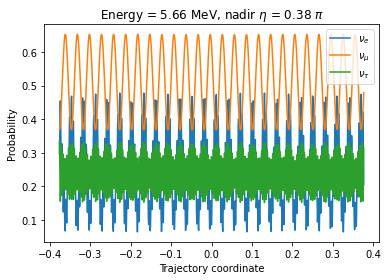

In [77]:
probs = np.square(np.abs(sol))

plt.xlabel("Trajectory coordinate")
plt.ylabel("Probability")
plt.title("Energy = %.2f MeV, nadir $\eta$ = %.2f $\pi$" % (E, eta/pi))
plt.plot(x, probs, label=["$\\nu_e$", "$\\nu_\mu$", "$\\nu_\\tau$"])
plt.legend()

plt.show()

# Not used anymore

In [51]:
# # Works for eta=0, check for different values

# DeltamSq21 = 7.42e-5
# DeltamSq31 = 2.514e-3
# E = 10
# [th12, th13, th23, d] = [0.583638, 0.149575, 0.855211, 3.40339]
# eta = 0

# from math import sin, cos
# from cmath import exp
# from scipy.linalg import expm
# from numpy.linalg import multi_dot

# R_E = 6.371e6 # meters

# def R23(th):
#     return np.matrix([
#         [1, 0, 0],
#         [0, cos(th), sin(th)],
#         [0, -sin(th), cos(th)]
#     ])

# def R13(th):
#     return np.matrix([
#         [cos(th), 0, sin(th)],
#         [0, 1, 0],
#         [-sin(th), 0, cos(th)]
#     ])

# def R12(th):
#     return np.matrix([
#         [cos(th), sin(th), 0],
#         [-sin(th), cos(th), 0],
#         [0, 0, 1]
#     ])

# def Delta(d):
#     return np.matrix([
#         [1, 0, 0],
#         [0, 1, 0],
#         [0, 0, exp(1j*d)]
#     ])


# [k1, k2, k3] = 2.533 * np.array([0, DeltamSq21, DeltamSq31]) / E

# r13 = R13(th13)
# r12 = R12(th12)
# r23 = R23(th23)
# delta = Delta(d)

# pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

# k = np.matrix(np.diag([k1, k2, k3]))

# H0 = r13 * r12 * k * r12.transpose() * r13.transpose()

# H2_12 = (k2 - k1) * cos(th12) * cos(th13) * sin(th12)
# H2_13 = sin(th13) * cos(th13) * ((k2 - k1) * (2 * cos(th12)**2 - 1) + 2 * k3 - k1 - k2) / 2
# H2 = np.array([
#     [0, H2_12, H2_13],
#     [-H2_12, 0, 0],
#     [-H2_13, 0, 0]
# ])

# ME_density = EarthDensity(eta=eta, integrated=True)

# # Need to understand if R_E or R_E^2 in ME2!
# ME1 = [- 1j * R_E * (H0 * ME_density[0][shell] + np.diag([3.868e-7 * (ME_density[1][shell]), 0, 0]) ) for shell in range(len(ME_density[0]))]
# ME2 = [- np.matrix(R_E**2 * H2 * 3.868e-7 * (ME_density[2][shell]) / 2) for shell in range(len(ME_density[0]))]

# ME12 = [expm(ME1[i] + ME2[i]) for i in reversed(range(len(ME1)))]

# evolutor_half = multi_dot(ME12) if len(ME12) > 1 else ME12[0]

# evolutor = multi_dot([r23, delta.conjugate(), evolutor_half, evolutor_half.transpose(), delta, r23.transpose()])

# probabilities = np.square(np.abs(evolutor * pmns[:,1].conjugate()))

# probabilities